# Mixture of experts

In this example we are going to approximate a piece wise continuous function using an expert mixture of metamodels.

The metamodels will be represented by the family of $f_k \forall \in [1, N]$:

$$f(\underline{x}) = f_1(\underline{x}) \quad \forall \underline{z} \in Class\, 1$$
 
$$\dots$$

$$f(\underline{x}) = f_k(\underline{x}) \quad \forall \underline{z} \in Class\, k$$

$$\dots$$

$$f(\underline{x}) = f_N(\underline{x}) \quad \forall \underline{z} \in Class\, N$$
 
where the N classes are defined by the classifier.

Using the supervised mode the classifier partitions the input and output space at once:

$$ z =(\underline{x}, f( \underline{x})) $$

The classifier is MixtureClassifier based on a MixtureDistribution defined as:
$$  p(\underline{x}) = \sum_{i=1}^N w_ip_i(\underline{x})$$


The rule to assign a point to a class is defined as follows: $\underline{x}$ is assigned to the class $j=argmax_j \log w_kp_k(\underline{z})$.

The grade of $\underline{x}$ with respect to the class $k$ is $\log w_kp_k(\underline{x})$.



In [62]:
from __future__ import print_function
import openturns as ot
from matplotlib import pyplot as plt
from openturns.viewer import View

In [63]:
dimension = 1

# Define the piecewise model we want to rebuild
def piecewise(X):
    x = X[0]
    if x < 0.0:
        f = (x+0.75)**2-0.75**2
    else:
        f = 2.0-x**2
    return [f]
f = ot.PythonFunction(1, 1, piecewise)

In [64]:
# Build a metamodel over each segment
degree = 5
samplingSize = 100
enumerateFunction = ot.LinearEnumerateFunction(dimension)
productBasis = ot.OrthogonalProductPolynomialFactory([ot.LegendreFactory()] * dimension, enumerateFunction)
adaptiveStrategy = ot.FixedStrategy(productBasis, enumerateFunction.getStrataCumulatedCardinal(degree))
projectionStrategy = ot.LeastSquaresStrategy(ot.MonteCarloExperiment(samplingSize))

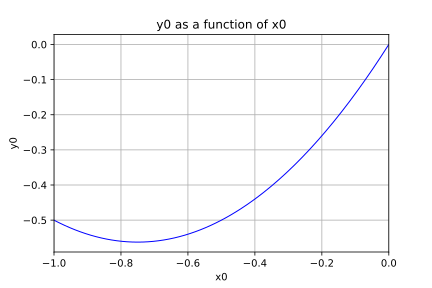

In [65]:
# Segment 1: (-1.0; 0.0)
d1 = ot.Uniform(-1.0, 0.0)
fc1 = ot.FunctionalChaosAlgorithm(f, d1, adaptiveStrategy, projectionStrategy)
fc1.run()
mm1 = fc1.getResult().getMetaModel()
f.draw(-1.0, -1e-6)

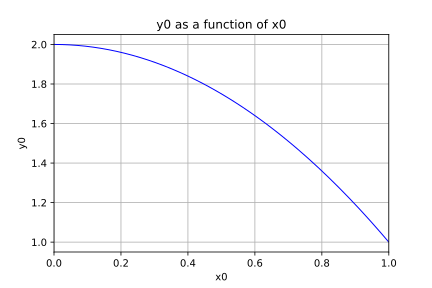

In [66]:
# Segment 2: (0.0, 1.0)
d2 = ot.Uniform(0.0, 1.0)
fc2 = ot.FunctionalChaosAlgorithm(f, d2, adaptiveStrategy, projectionStrategy)
fc2.run()
mm2 = fc2.getResult().getMetaModel()
f.draw(1e-6,1.0)

In [67]:
# Define the mixture
R = ot.CorrelationMatrix(2)
d1 = ot.Normal([-1.0, -1.0], [1.0]*2, R)# segment 1
d2 = ot.Normal([1.0, 1.0], [1.0]*2, R)# segment 2
weights = [1.0]*2
atoms = [d1, d2]
mixture = ot.Mixture(atoms, weights)

In [68]:
# Create the classifier based on the mixture
classifier = ot.MixtureClassifier(mixture)

In [69]:
# Create local experts using the metamodels
experts = ot.Basis([mm1, mm2])

In [70]:
# Create a mixture of experts
evaluation = ot.ExpertMixture(experts, classifier)
moe = ot.Function(evaluation)

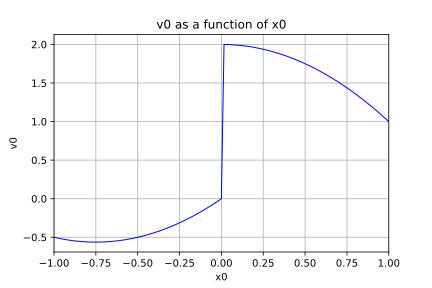

In [71]:
# Draw the mixture of experts
moe.draw(-1.0, 1.0)